<a href="https://colab.research.google.com/github/auroramugnai/Minimum-Exact-Cover-Problem/blob/main/MECP_with-QAOA/QAOA_random_parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the MECP with QAOA+ using "Random Parameters" technique

In [1]:
# Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# %cd /content/drive/MyDrive/ICFO_CODICI/progetto/MECP_with-QAOA
# ! pip install -r requirements.txt

## Import Modules & Define Functions

In [1]:
from __future__ import annotations
from utils_to_build_QAOAAnsatz import *

In [2]:
from datetime import datetime
import math
import random
import time

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from scipy.optimize import minimize
from pprint import pprint # to print dictionaries

In [3]:
def write_params_on_file(DATA_FILE, params):

    DATA_FILE.write("\nChosen parameters:\n")
    DATA_FILE.write(f"Number of layers (p): {params['p']}\n")
    DATA_FILE.write(f"Number of random attempts: {params['random_attempts']}\n")
    DATA_FILE.write(f"Initialization type: {params['init_string']}\n")
    DATA_FILE.write(f"Size (n): {params['n']}\n")
    DATA_FILE.write(f"Chosen instances (chosen_instances): {params['chosen_instances']}\n")
    DATA_FILE.write(f"Choices of k (chosen_ks): {params['chosen_ks']}\n")


    # Display the chosen parameters
    print(f"######### ...Writing on file...: #########")
    print("Chosen parameters:")
    print(f"Number of layers (p): {params['p']}")
    print(f"Number of random attempts: {params['random_attempts']}")
    print(f"Initialization type: {params['init_string']}")
    print(f"Size (n): {params['n']}")
    print(f"Chosen instances (chosen_instances): {params['chosen_instances']}")
    print(f"Choice of ks (chosen_ks): {params['chosen_ks']}")
    print(f"##########################################")

def compute_L_EC(info_dim6):
    """ For each instance, compute the number of ones in each exact cover string
    that is not the mec string."""
    L_ECs = []
    for key in info_dim6:  
        if key != 'U':
            ec_strings = info_dim6[key]['exact_covers']
            mec_string = info_dim6[key]['mec']
            for ec in ec_strings:
                if ec != mec_string:
                    L_ECs.append(ec.count('1'))
    print("L_ECs:", L_ECs)
    return L_ECs

def compute_L_MEC(info_dim6):
    """ For each instance, compute the number of ones in the mec string."""
    L_MECs = []
    for key in info_dim6:  
        if key != 'U':
            mec_string = info_dim6[key]['mec']
            L_MECs.append(mec_string.count('1'))
    print("L_MECs:", L_MECs)
    return L_MECs

def compute_L_from_k(info_dim6, k):
    """ Compute L from k, where k is a parameter that we choose.
    k = L/(min_length * n) so L = k * min_length * n
    where min_length is the minimum number of elements in a subset of an instance 
    and n is the number of subsets in the instance.
    Parameters
    ----------
    k : float
        The parameter k.
    info_dim6 : dict
        The dictionary containing the instances information.
    Returns
    -------
    Ls : list
        A list of L values computed from k for each instance.
    """
    n = 6  
    Ls = []
    for instance in info_dim6.keys():
        if instance == 'U':
            continue
        min_length = min(len(s) for s in info_dim6[instance]['subsets'])
        Ls.append(int(k * min_length * n))

    print(f"Ls from k={k}:", Ls)



In [5]:
from random_instances import info_dim6
compute_L_EC(info_dim6)
compute_L_MEC(info_dim6)
compute_L_from_k(info_dim6, 1)


L_ECs: [3, 4, 4, 3, 4, 3, 4, 3, 4, 3]
L_MECs: [2, 3, 3, 2, 3, 2, 3, 2, 3, 2]
Ls from k=1: [12, 12, 12, 12, 12, 18, 12, 18, 12, 18]


## Set Parameters

In [4]:
### Get parameters from the user
params = get_parameters_from_user()

# Get the parameters separately
chosen_instances = params['chosen_instances']
chosen_ks = params['chosen_ks']
p = params['p']
random_attempts = params['random_attempts']
init_string = params['init_string']

n = params['n']

Number of layers (p), default is 4:  
Number of random attempts, default is 50:  
String initialization (all1 or all0), default is all0:  
Size n (6, 8, 10), default is 6:  
Chosen instances, default is [1, ..., 10] (Give a list please!):  [5]
Choice for L, to compute k as L/(min_length * n). Give a list specifying L for every instance chosen please. [12]


## For Every Instance Chosen, Do the Minimization
This code iterates through selected instances, generating corresponding subsets and computing the spectrum of states, including Minimum Exact Cover (MEC) states. It then builds the quantum circuits for the QAOA+ algorithm, including cost, mixing, and initialization circuits. Initial angles (betas and gammas) are randomly set within specified bounds, and the QAOA+ algorithm is run for multiple random initializations to minimize energy. Results, such as the optimal parameters, best attempt, minimum energy, and elapsed time, are recorded. Final data of each instance is saved in a .csv and a .txt.



Saving in folder_path = random_parameters_2025-09-09@17h34m46s
1.0 5
**************************************************
Instance 5 with h = 1.0

U, subsets, EXACT_COVERS, MEC {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12} [{9, 11}, {5, 6}, {1, 2, 4, 5, 7, 8, 9, 10, 11, 12}, {10, 12}, {10, 12, 5, 6}, {1, 2, 3, 4, 7, 8}] ['100011', '110101'] ['100011']


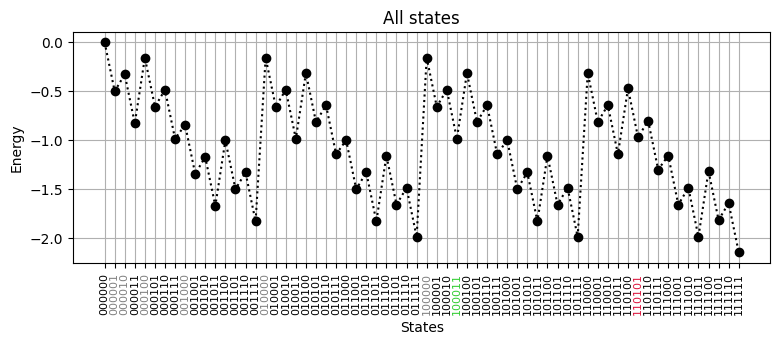

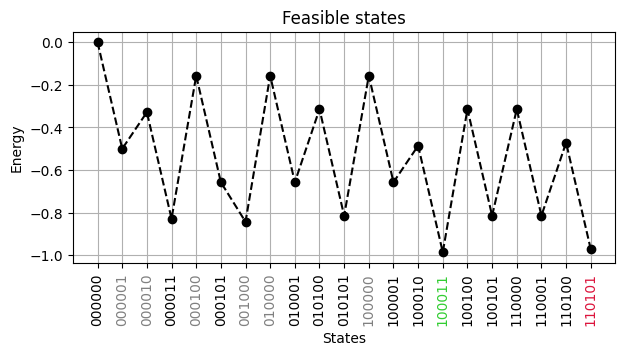

Universe: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Subsets:
  1: {9, 11}
  2: {5, 6}
  3: {1, 2, 4, 5, 7, 8, 9, 10, 11, 12}
  4: {10, 12}
  5: {10, 12, 5, 6}
  6: {1, 2, 3, 4, 7, 8}
num_max_ctrl: 5
NUM_ANC: 4
QC_DIM: 10
A = 1.1142857142857143
B = 0.04285714285714286
constant = -A + B = -1.0714285714285714

hamiltonian:
 SparsePauliOp(['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIIZIIII', 'IIIIZIIIII'],
              coeffs=[0.07857143+0.j, 0.07857143+0.j, 0.42142857+0.j, 0.07857143+0.j,
 0.16428571+0.j, 0.25      +0.j])
Universe: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Subsets:
  1: {9, 11}
  2: {5, 6}
  3: {1, 2, 4, 5, 7, 8, 9, 10, 11, 12}
  4: {10, 12}
  5: {10, 12, 5, 6}
  6: {1, 2, 3, 4, 7, 8}
num_max_ctrl: 5
NUM_ANC: 4
QC_DIM: 10
Mixing circuit created for instance 5 with 6 qubits.
Circuit dimension (QC_DIM): 10
Number of ancillas: 4
Number of control gates: 5
Universe: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Subsets:
  1: {9, 11}
  2: {5, 6}
  3: {1, 2, 4, 5, 7, 8,

/tmp/ipykernel_257/2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.8050651177553079
E_min = result.fun = 0.26636345367326353

Optimal parameters: betas, gammas = [5.544146632603955, 2.1140156787817297, 4.169847587190766, 2.9561563656321086], [-2.5678161706735105, 3.8019804880223447, -9.995976625038061, -2.780576567726585]
--> ***UPDATING THE BEST ATTEMPT***

    states  counts_p4_1of50
13  100101              288
11  100011              212
9   100001              198
6   001000               58
16  110101               53
8   010101               50
3   000011               48
15  110001               47
1   000001               30
7   010001               22
4   000100                6
10  100010                3
5   000101                2
12  100100                2
2   000010                2
14  110000                2
0   000000                1

---------- 2/50 random_attempts -----------

pars_0 = [2.645298412600338, 3.9714802101288202, 3.5801243842873998, 1.5537564958527628, 8.599110461030975, 8.60339721716

/tmp/ipykernel_257/2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9714332632701921
E_min = result.fun = 0.09999530815837937

Optimal parameters: betas, gammas = [6.28255853536875, 3.1417120231289832, 0.6533823901679408, 5.630863721579479], [-4.113967569484336, 0.8002638318847026, 9.995976625058432, -0.0023932837588208156]
--> ***UPDATING THE BEST ATTEMPT***

   states  counts_p4_3of50
0  110101             1024

---------- 4/50 random_attempts -----------

pars_0 = [5.459651866139767, 5.643665956724297, 3.0176844302475283, 5.55299782957894, -3.7388981566134527, 6.387610679003249, -1.4079620618780648, 3.9536308163394516]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated successfully.
         Current function value: 0.100000
         Iterations: 357
         Function evaluations

/tmp/ipykernel_257/2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.801641095883901
E_min = result.fun = 0.2697874755446704

Optimal parameters: betas, gammas = [5.499647669275182, 2.1064083433707728, 4.06579597875208, 3.1057847505246476], [9.995976625058432, -3.98146848987267, 9.995848039650149, -9.755530455097588]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_5of50
15  100101              305
13  100011              190
11  100001              187
19  110101               71
5   001000               68
2   000011               51
9   010101               46
17  110001               28
7   010001               27
1   000001               26
14  100100               10
4   000101                5
16  110000                2
12  100010                2
18  110100                1
0   000000                1
8   010100                1
6   010000                1
3   000100                1
10  100000                1

---------- 6/50 random_attempts -----------

pars_0 = [5.017710753380805, 3.669709057

In [ ]:
current_datetime = datetime.now().strftime("%Y-%m-%d@%Hh%Mm%Ss")

# Create a  directory where to collect files
folder_path = f"random_parameters_{current_datetime}"
print(f"Saving in folder_path = {folder_path}")
os.makedirs(folder_path, exist_ok=True)

# Run QAOA+ for every instance.
for h, instance in zip(chosen_ks, chosen_instances):
    print(h, instance)
    print("*"*50)
    print(f"Instance {instance} with h = {h}\n")

    FILENAME_list = [] # list of .csv containing the final histograms data.
    DATA_FILENAME_list = [] # list of .txt containing metadata such as energies, betas, gammas.


    # Define the instance.
    U, subsets_dict = define_instance(n, instance, verbose=False)
    subsets = list(subsets_dict.values())
    _, _, _, _, EXACT_COVERS = find_spectrum(U, subsets_dict, n, h)
    MEC = [state for state in EXACT_COVERS if state.count("1") == min([x.count("1")  for x in EXACT_COVERS])]

    print("U, subsets, EXACT_COVERS, MEC", U, subsets, EXACT_COVERS, MEC)

    # Plot states vs energy.
    show_spectrum(n, instance, h, fontsize=10)


    # Choose the initialization.
    if init_string == 'all1':
        # Only "1"-states.
        init_name = ["".join(elem) for elem in distinct_permutations('0'*(n-1) + '1')]

    elif init_string == 'all0':
        init_name = ["000000"]


    # Prepare the cost and mixing circuit.
    constant, hamiltonian, qc_cost = build_cost_circuit(n, instance, h, verbose=True)
    qc_mixing = build_mixing_circuit(n, instance,verbose=True)
    qc_initial, check_counts  = build_initialization_circuit(n, instance, init_name, verbose=True)

    # # Check that initialization was correct.
    # plot_histogram(check_counts, ax=plt.subplots()[1], title="Initialization check", color='k')
    # plt.show(block=False) # don't stop execution


    # Set initial angles.
    gamma_bound = find_gamma_bound(n, instance, h, verbose=True)

    beta_0 = (0, 2*np.pi)
    gamma_0 =  (-gamma_bound, gamma_bound)
    string_0 = f"[0,2pi]x[-{gamma_bound},{gamma_bound}]"

    bnds_beta = (0, 2*np.pi)
    bnds_gamma = (-gamma_bound, gamma_bound)
    bnds_string = f"[0,2pi]x[-{gamma_bound},{gamma_bound}]"


    # Build files' names.
    header = f"dim{n}_mail{instance}_{init_string}" \
           + f"_random_p{p}_{random_attempts}ra_k{h}" \
           + f"_BOUNDS{bnds_string}_pars0{string_0}"

    FILENAME = os.path.join(folder_path, header + f".csv")
    DATA_FILENAME = os.path.join(folder_path, header + f"_data.txt")

    FILENAME_list.append(FILENAME)
    DATA_FILENAME_list.append(DATA_FILENAME)


    # Record the details of each attempt in a file.
    with open(DATA_FILENAME, 'a') as DATA_FILE:
        write_params_on_file(DATA_FILE, params) # Write global parameters

        E_best = 100
        TOTAL_start_time = time.time()

        for attempt in range(1,random_attempts+1):
            print(f"\n---------- {attempt}/{random_attempts} random_attempts -----------\n")
            DATA_FILE.write(f"\n---------- {attempt}/{random_attempts} random_attempts -----------\n")

            # Build QAOAAnsatz.
            cost_vs_iteration = [] # to save (and plot) iterations
            ansatz = QAOAAnsatz(qc_cost,
                                mixer_operator=qc_mixing,
                                initial_state=qc_initial,
                                reps=p, name='QAOA+')


            # Generate a pass manager without providing a backend.
            pm = generate_preset_pass_manager(optimization_level=3)
            ansatz_isa = pm.run(ansatz)
            hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)

            estimator = StatevectorEstimator()
            sampler = StatevectorSampler()


            # *************************  FIND OPTIMAL ANGLES  ***************************
            # *************************     THROUGH QAOA+     ***************************

            # Set initial angles and angles'bounds.
            pars_0 = [random.uniform(*beta_0) for _ in range(p)] + \
                     [random.uniform(*gamma_0) for _ in range(p)]
            bnds = [bnds_beta]*p + [bnds_gamma]*p

            print(f"pars_0 = {pars_0}")
            print(f"bnds = {bnds}\n")


            # Do the minimization.
            result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations
                              pars_0, bounds=bnds,
                              args=(ansatz_isa, hamiltonian_isa, estimator),
                              method="Nelder-Mead",
                              options={"disp": True, "maxiter": 1200, "maxfev": 1200}, tol=1e-4)


            # Works only if you chose cost_func_plot.
            if cost_vs_iteration != []:
                plt.figure()
                plt.plot(cost_vs_iteration)
                plt.xlabel("Iteration")
                plt.ylabel("Cost")
                plt.show()


            # Minimum energy reached with minimization.
            E_min = result.fun + constant
            print(f"E_min = result.fun + constant = {E_min}")
            print(f"E_min = result.fun = {result.fun}")
            DATA_FILE.write(f"\nE_min = {E_min}")


            # Optimal parameters (betas, gammas) found.
            betas = list(result.x[:p])
            gammas = list(result.x[p:])
            print(f"\nOptimal parameters: betas, gammas = {betas}, {gammas}")
            DATA_FILE.write(f'\nE_min\'s parameters: betas = {betas}, gammas = {gammas}\n')


            # Update the best attempt.
            if E_min < E_best:
                    E_best = E_min
                    best_attempt = attempt
                    print("--> ***UPDATING THE BEST ATTEMPT***\n")
            else:
                print("--> ***NOT UPDATING THE BEST ATTEMPT***\n")


            # ****************************  RUN THE CIRCUIT  ******************************
            # ************************ WITH OPTIMAL PARAMETERS ****************************

            # Assign to the previously created ansatz the 2p parameters found.
            pars = betas + gammas
            qc = ansatz.assign_parameters(pars)
            qc.measure_all() # add a measurement

            # Run this circuit.
            qc_isa = pm.run(qc)
            output = sampler.run([qc_isa], shots=1024).result()
            samp_dist = output[0].data.meas.get_counts()


            # ****************************  POST PROCESS  **********************************
            # *********************** AND SAVE THE OUTPUT HISTOGRAM ************************

            # Create a dataframe from the sampling results.
            df = pd.DataFrame(samp_dist.items(), columns=['states', 'counts'])

            # Remove ancillary bits.
            num_ancillas = get_circuit_parameters(subsets, verbose=False)[2]
            df['states'] = df['states'].apply(lambda x: x[num_ancillas:])

            # Invert the bit order for the states (e.g., convert "01101" to "10110").
            df['states'] = df['states'].apply(lambda s: str(s)[::-1])  # Invertiamo l'ordine dei bit

            # After removing the ancillary bits, we aggregate counts by state.
            df = df.groupby(['states']).sum().reset_index()

            # Sort in decreasing order.
            df = df.sort_values('counts', ascending=False)

            # Rename the "counts" column to include attempt details.
            df.columns = ['states', f'counts_p{p}_{attempt}of{random_attempts}']

            # Merge the current attempt dataframe with previously built dataframes.
            if attempt == 1:
                df_all_attempts = df
            else:
                df_all_attempts = pd.merge(df_all_attempts, df, on="states", how="outer")
            
            print(df)


        # Save to .csv the global dataframe.
        df_all_attempts.to_csv(FILENAME, index=False)


        # Plot the best attempt (minimum energy), with error bars
        # representing other attempts in the global dataframe.
        plot_histogram_of_best_column(df_all_attempts,
                                      f'counts_p{p}_{best_attempt}of{random_attempts}',
                                      EXACT_COVERS, init_name,
                                      fontsize=12, title=f"Result (best attempt) for instance {instance}")


        DATA_FILE.write("\n*******************************")
        DATA_FILE.write(f"\nAttempt that reached the best result with E_min = {E_best} is #{best_attempt} ")
        DATA_FILE.write(f"\nTOTAL ELAPSED TIME: {(time.time() - TOTAL_start_time)/60} minutes.\n")
        print(f"Result saved in:\n{FILENAME}\n{DATA_FILENAME}")
        print(f"\nTOTAL ELAPSED TIME: {(time.time() - TOTAL_start_time)/60} minutes.")

## (Optional) Draw the latest instance QAOA circuit

In [ ]:
'110101', '100011'

print(f"Instance #{instance}")
ansatz.decompose(reps=2).draw("mpl")

## Plot from a saved folder ...
### ... for each instance, the best attempt (with also mean and error displayed) or...
Plot the results of all chosen instances for which QAOA has been computed or plot results from a previous run.

The `find_files_containing_string` function will search for `.csv` and `.txt` files in the selected `path`. If provided, it will also search for files that contain a specific string of text.

In [ ]:
# Uncomment this line to plot data from an existing directory
# folder_path = "random_parameters_2025-07-21@17h20m50s" # LEC
# folder_path = "random_parameters_2025-07-22@15h10m16s" # LEC-1

# folder_path = "random_parameters_2025-09-08@17h51m29s" # k=1
folder_path = "random_parameters_2025-09-07@11h51m23s" # L_EC

# Find the files that contain every string in 'substrings'.
FILENAME_list, DATA_FILENAME_list = find_files_containing_string(path= f"./{folder_path}/")

# Get the number of files collected.
num_files = len(FILENAME_list)

if num_files>1:
    plot_list_of_files(FILENAME_list, DATA_FILENAME_list,
                       colorchosen="steelblue", alpha=0.6,
                       init_name="all1",
                       dont_show_in_title=["i", "k"],
                       dont_show_in_titles=["n", "p", "ra", "init"],
                       figsize=(8,num_files+1),
                       dpi=200, N=9) # figsize=(10, 13), dpi=300, N=12 for latex figures
else:
    plot_file(FILENAME_list[0], DATA_FILENAME_list[0],
              colorchosen='indigo', alpha=0.4,
              dont_show_in_title = [],
              figsize=(10,4), dpi=200, N=10)

### ... for each instance, every single attempt

In [ ]:
# folder_path = "random_parameters_2025-01-30@09h03m50s"
plot_each_attempt_from_folder(folder_path)

In [ ]:
print(info_dim6)
